In [1]:
import numpy as np
import helper


## Load Preprocessed Data

In [2]:
data = np.load('../preprocessing/preprocessed_oh.npz' ,allow_pickle= True)
text_vec = data['text_word2vec']
summary_vec = data['summary_word2vec']
text_existence = data['text_existence']
text_count = data['text_count']
summary_existence = data['summary_existence']
summary_count = data['summary_count']
labels = data["labels"]
text_voc_size = data['text_voc_size']
sum_voc_size = data['summary_voc_size']

# Experiments with existence of words in a text

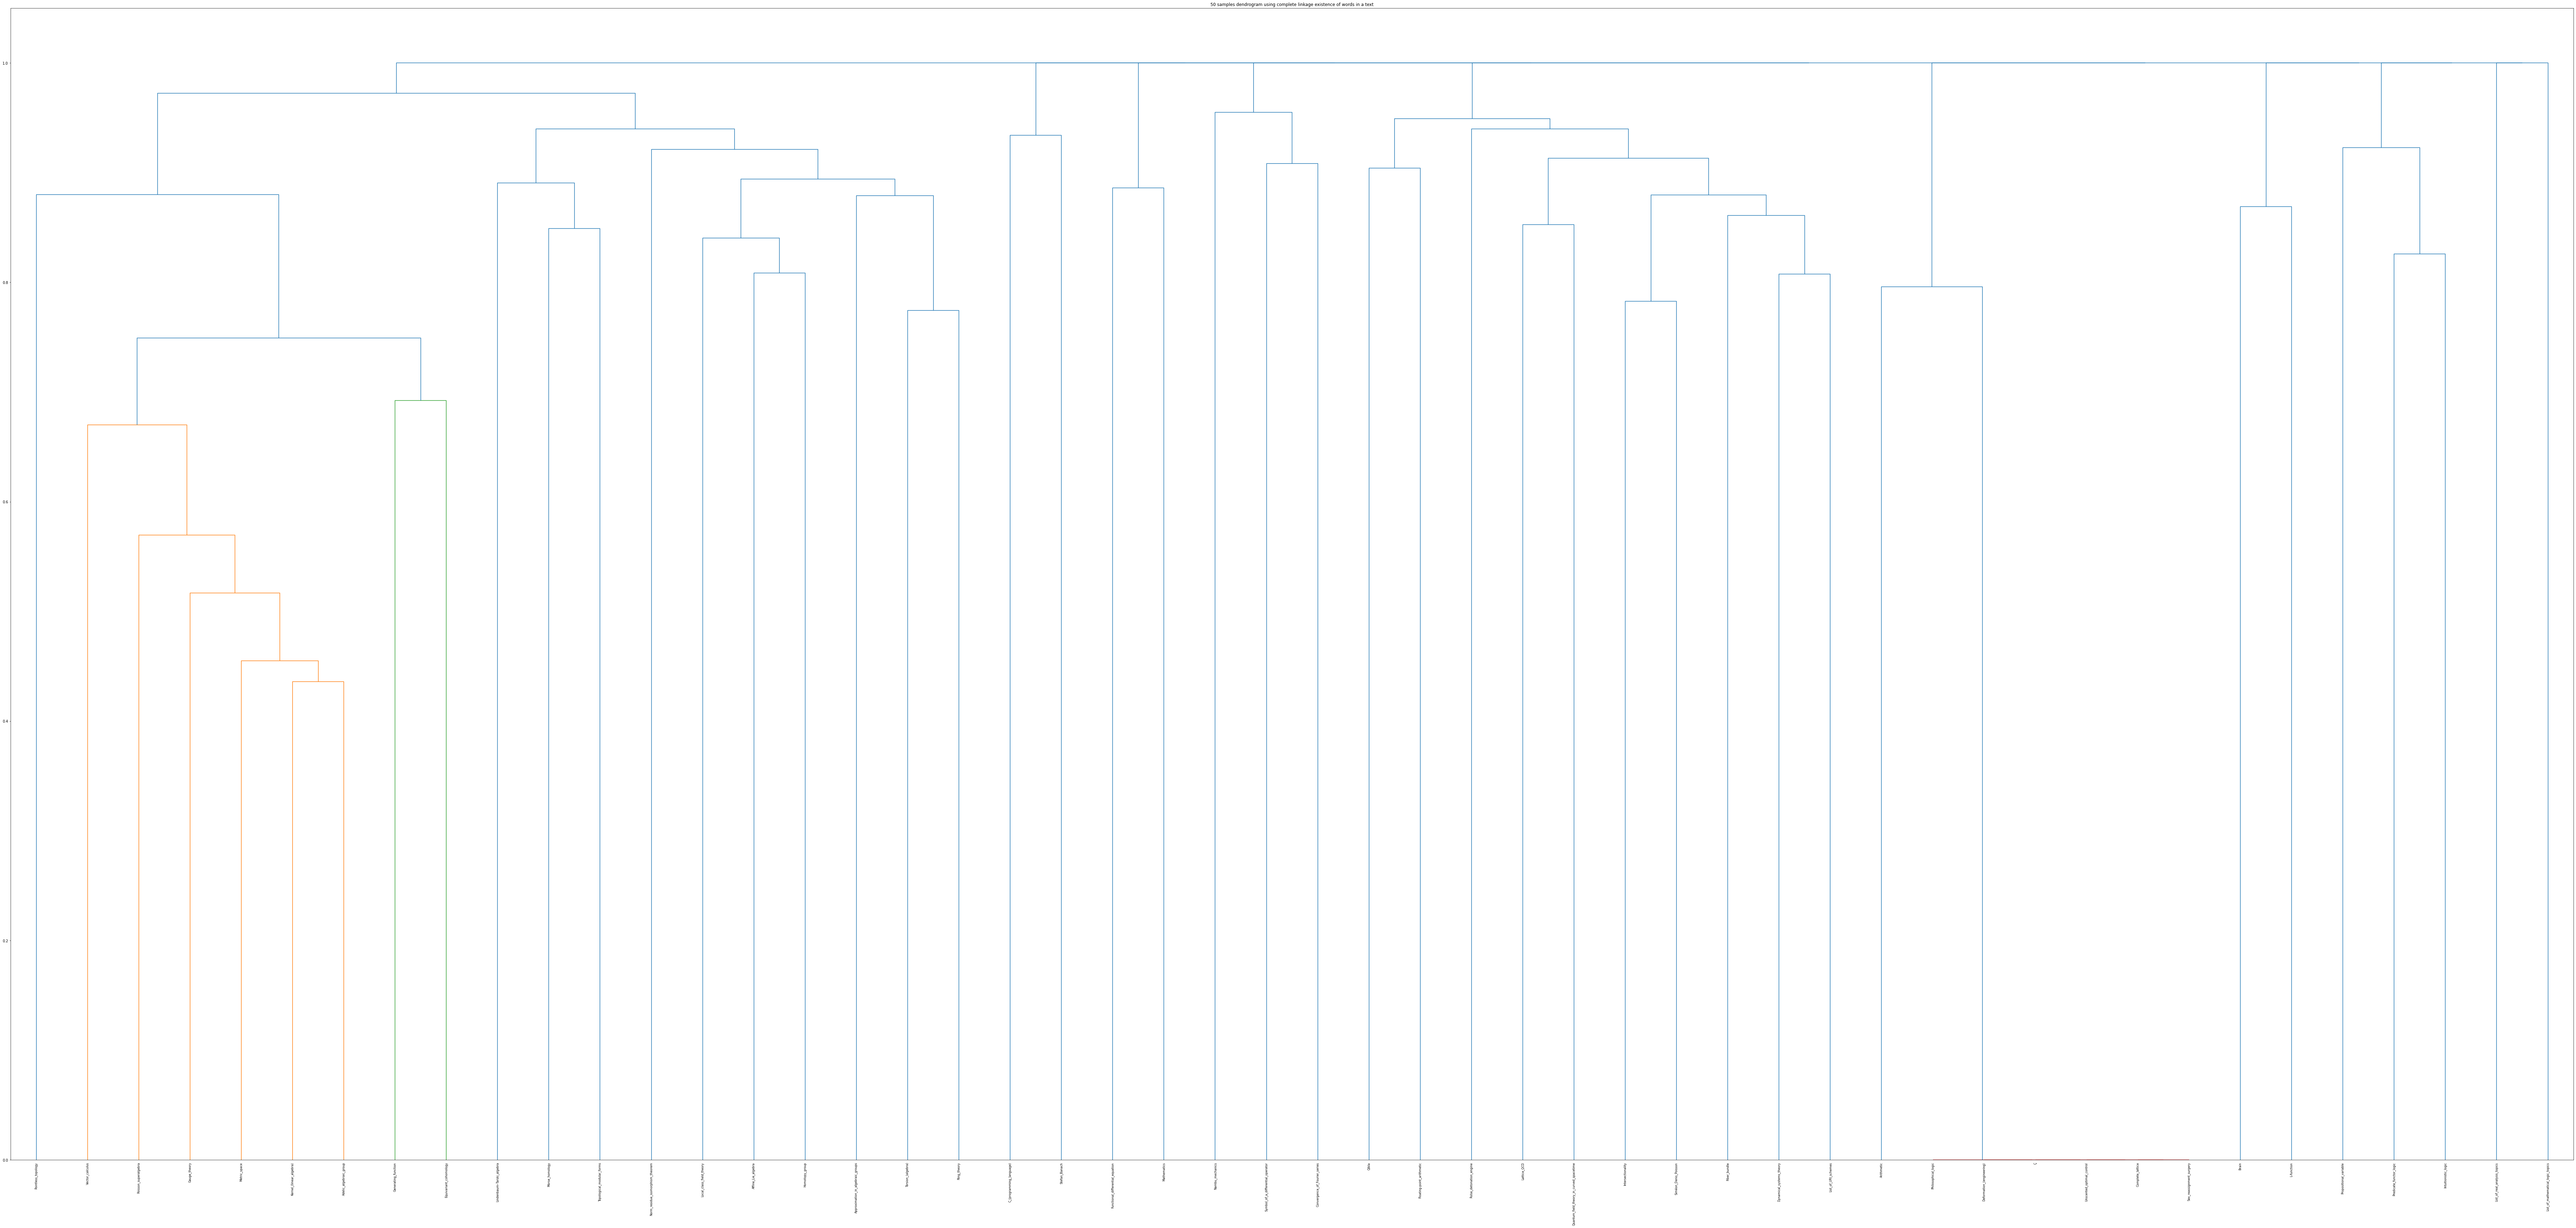

In [3]:
# helper.plot_tsne(text_existence,labels,perplexity =50)
helper.plot_dendrogram(text_existence,title = "50 samples dendrogram using complete linkage existence of words in a text",titles_list = labels)

shape reduced matrix: (50, 2)
pca.explained_variance_ratio_: [0.09826779 0.08109815]


array([[-0.72846889,  0.16770058],
       [-0.58998703,  0.09052141],
       [-0.36958398,  0.39055064],
       [-1.07632226,  0.18732844],
       [-0.84306405,  0.07975678],
       [-0.92537747,  0.28588536],
       [-0.81379173,  0.19376957],
       [-0.94826103,  0.17930755],
       [-0.81379173,  0.19376957],
       [ 2.83185781, -1.53369614],
       [ 6.56485249,  9.75407786],
       [-0.81379173,  0.19376957],
       [-0.93908151,  0.24745841],
       [-0.74759764, -0.02225167],
       [-0.81379173,  0.19376957],
       [-0.5129148 ,  0.15504459],
       [ 0.44609083, -0.3631288 ],
       [ 0.05702864, -0.33030265],
       [ 2.47110947, -0.78768308],
       [-1.07808286,  0.2720256 ],
       [-0.77810593, -0.02798011],
       [-1.23744755,  0.23336218],
       [ 1.49345785, -0.93754979],
       [-1.25129022,  0.20740739],
       [-1.02540921,  0.11810804],
       [ 1.75870153, -0.6301056 ],
       [-0.47550685, -0.10812194],
       [-0.95448828, -0.02672192],
       [-1.19820901,

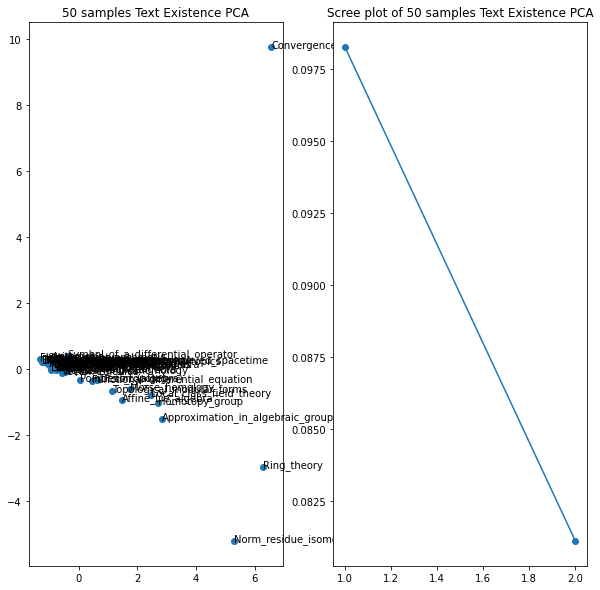

In [4]:
helper.plot_pca(text_existence,titles_list = labels, title = "50 samples Text Existence PCA")

In [16]:
text_existence.shape

(50, 1257)

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


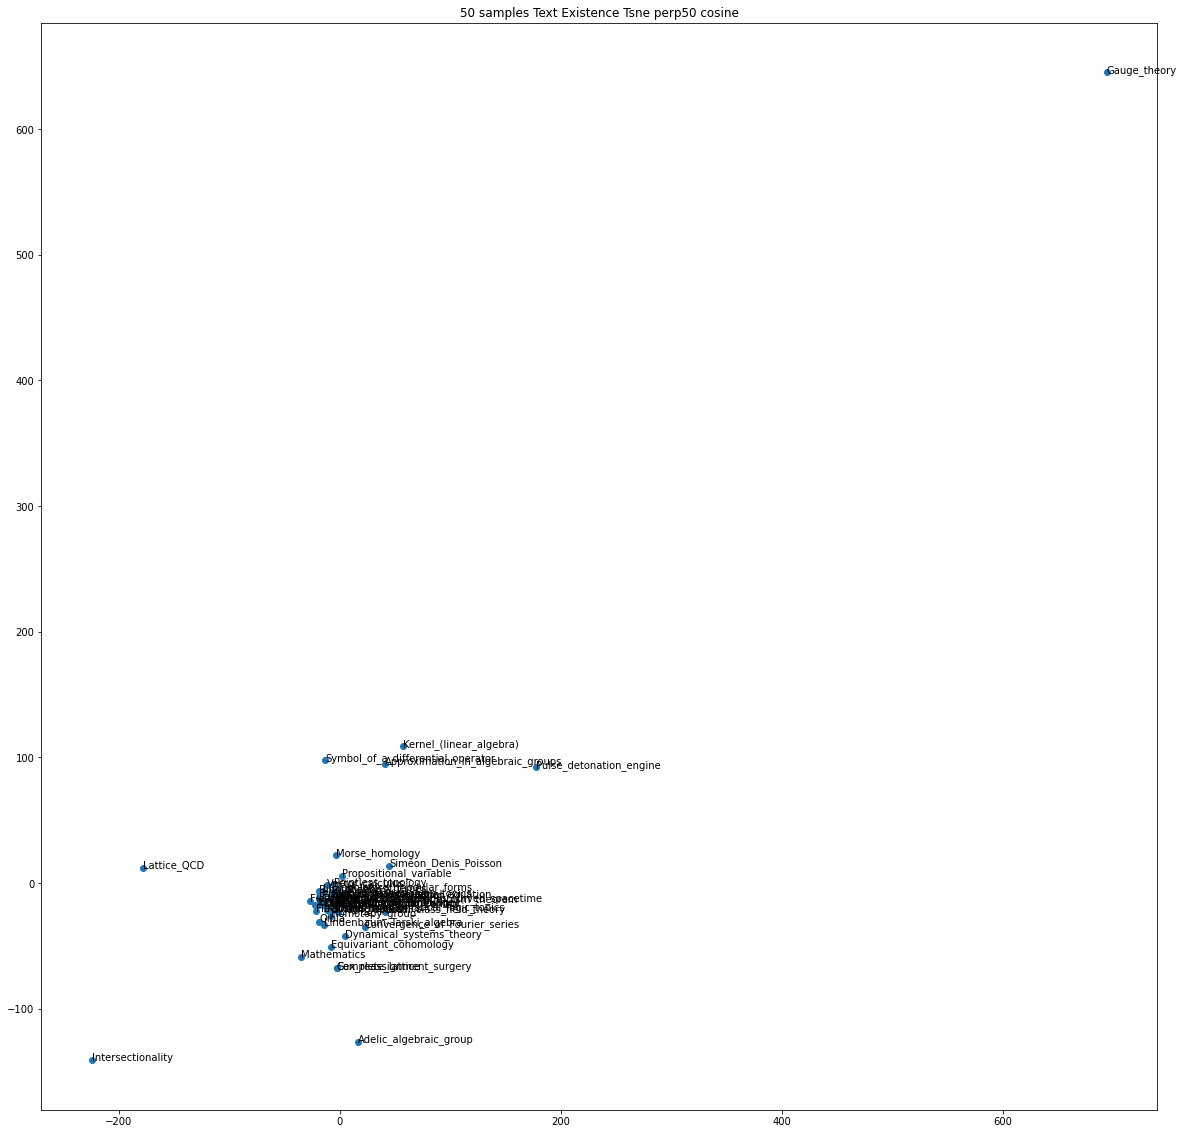

In [15]:
reduced_matrix = helper.plot_tsne(text_existence,labels,title="50 samples Text Existence Tsne perp50 cosine",metric= "cosine")

# Experiments with existence of words in a summary

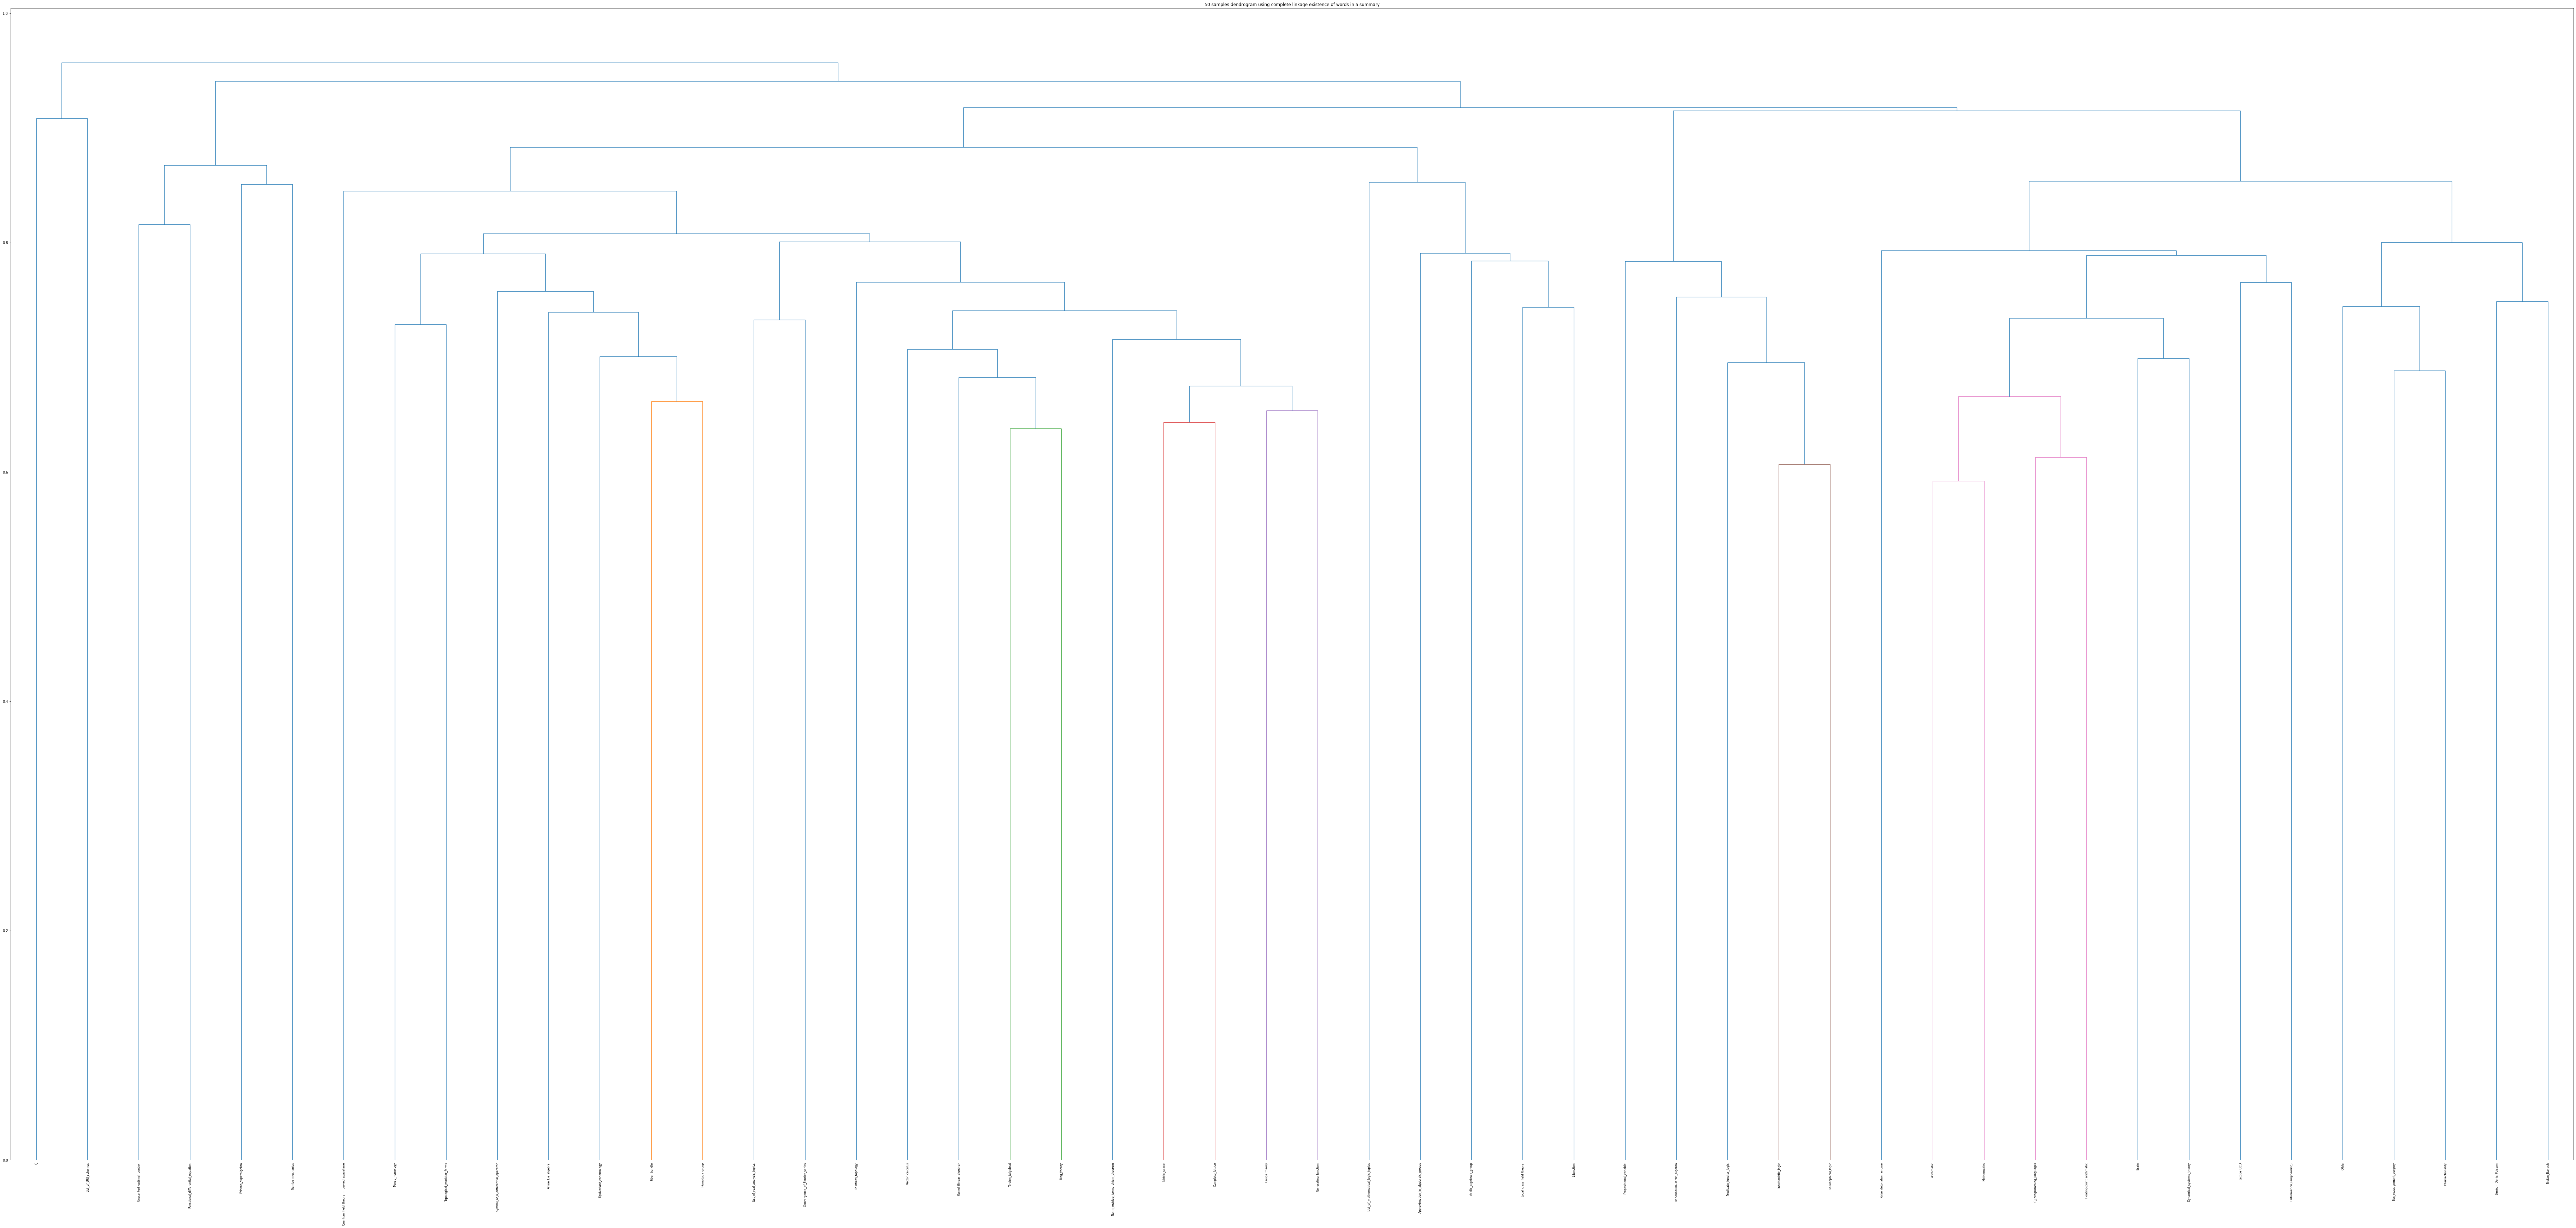

In [6]:
helper.plot_dendrogram(summary_existence,title = "50 samples dendrogram using complete linkage existence of words in a summary",titles_list = labels)

shape reduced matrix: (50, 2)
pca.explained_variance_ratio_: [0.12000139 0.06049054]


array([[ 1.51914869e-04,  1.88733204e+00],
       [-5.98312671e+00, -4.84530786e-01],
       [-5.43951465e+00, -6.01400095e-02],
       [-8.28569998e-01,  1.84554018e-01],
       [-3.08441619e+00,  1.06919838e+00],
       [ 7.09940181e+00,  2.67942761e+00],
       [-8.85688080e-01,  4.65552159e-01],
       [-4.49171065e+00,  1.80898434e-01],
       [ 8.77622592e+00, -3.75464585e+00],
       [-6.25299461e+00, -4.79108771e-01],
       [-1.37657249e+00,  1.33974077e+00],
       [-6.65299991e+00, -7.19635596e-01],
       [ 2.10450758e+01, -2.22438383e+01],
       [ 6.62276171e+00,  1.25133433e+00],
       [-4.96573849e+00, -5.21767819e-01],
       [ 4.46991477e+00,  4.19426056e+00],
       [-3.79322566e+00, -1.90687013e-01],
       [-3.40006934e+00, -1.19666247e-01],
       [-5.83986300e+00, -1.84793888e-01],
       [ 9.27530466e+00, -2.74986846e+00],
       [ 1.36142428e+00,  5.74000162e-01],
       [-1.23240158e-01, -9.88692651e-01],
       [-3.98210233e+00, -2.74502564e-02],
       [ 1.

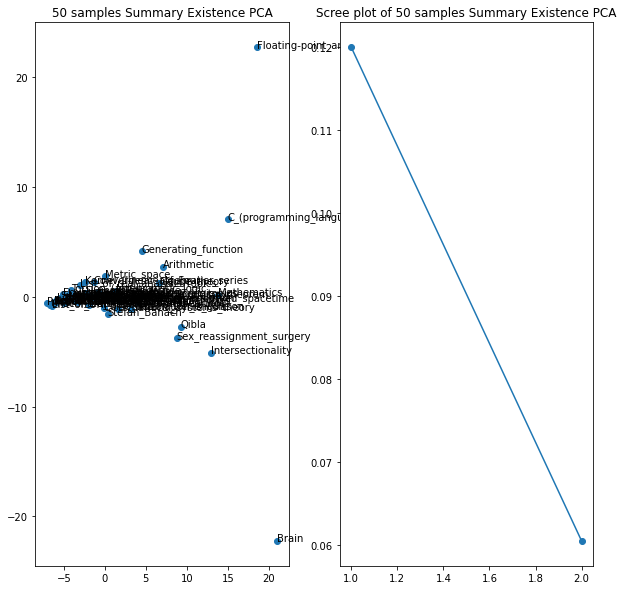

In [8]:
helper.plot_pca(summary_existence,titles_list = labels, title = "50 samples Summary Existence PCA")

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


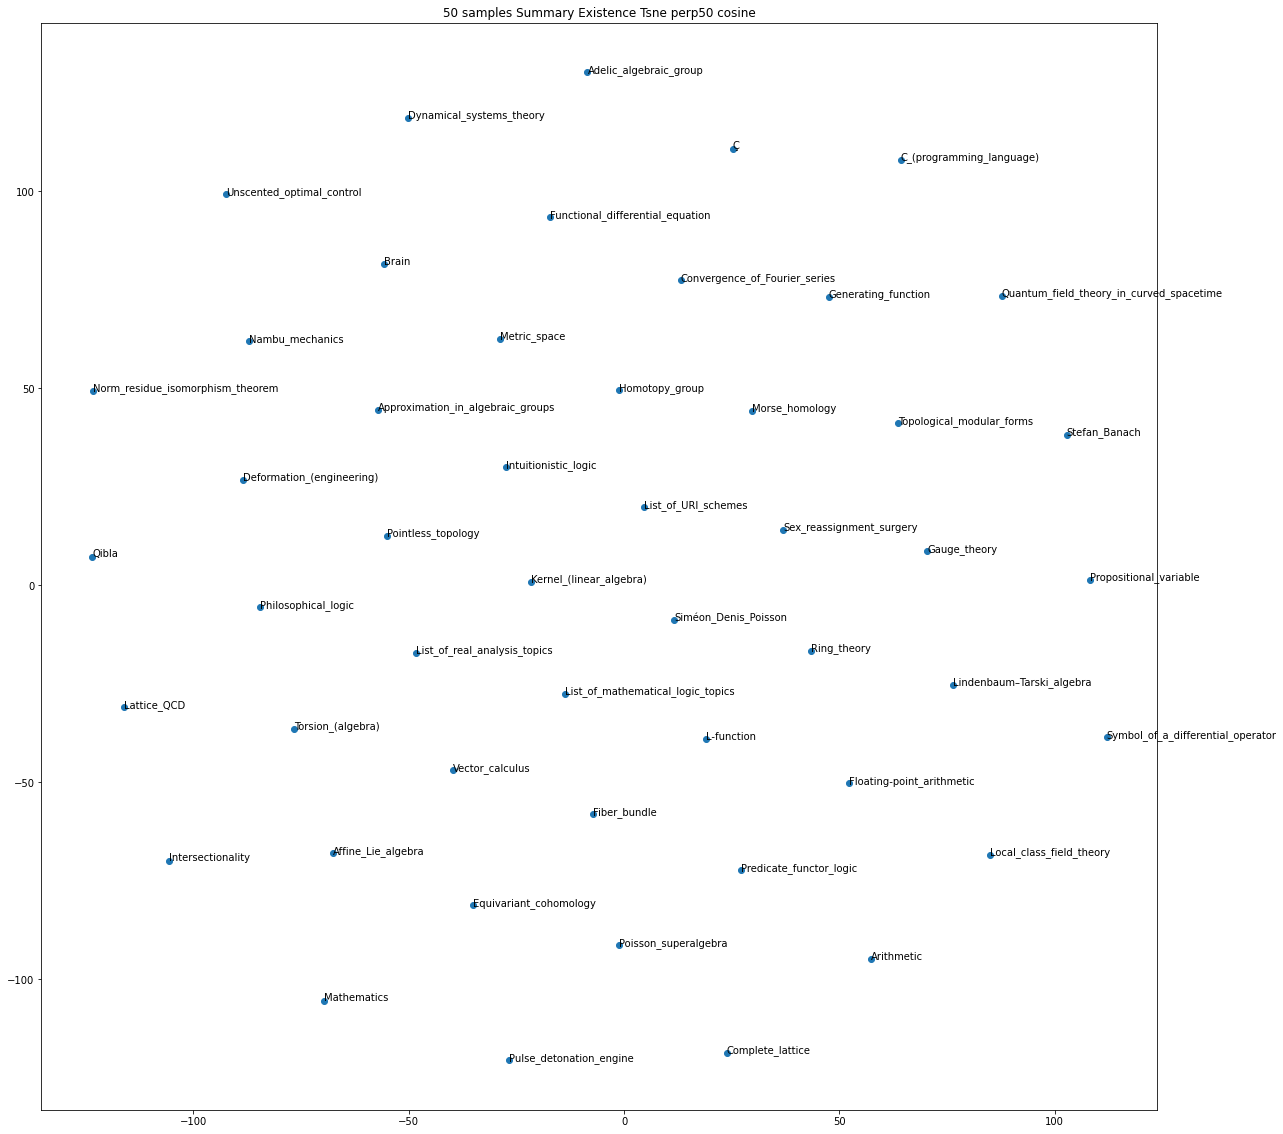

In [14]:
reduced_matrix = helper.plot_tsne(summary_existence,labels,title="50 samples Summary Existence Tsne perp50 cosine",metric= "cosine")